## Preprocessing the Input Data

- In the future step, several machine learning (ML) models will be created and compared: logistic regression, Random Forest, XGBoost, LightGBM, Isolation Forest, Local Outlier Factor (LOF), and Support Vector Machine (SVM). In this step, I will preprocess the data so they are ready to be fed into these models
- Technically, preprocessing requirements vary slightly among the models

**Methods Requiring Scaling**
- For the following methods, scaling is needed because they are sensitive to the scale:
    - Logistic Regression
    - Support Vector Machine (SVM)
    - LOF
- For the other methods (tree-based models), scaling is not necessary, but they can also use scaled data
- To make testing and comparisons more efficient, I will preprocess the data in this step so that they can be used in models that require scaling. Then in the next step, I will use the scaled data for all models being tested

**Steps**
- Separate 'Class' variable and covariates and split data into train/test
- Apply log transformation and RobustScaler() to 'Amount'
- Drop 'Amount' and 'Time'
- Apply Synthetic Minority Oversampling Technique (SMOTE) to training dataset to handle class imbalance
- Check feature correlation post-SMOTE
- Note: Based on what was seen in 01_eda, I will not apply further preprocessing to V1-V28 and I plan to keep V1-V28 in modeling in the next step unless dropping them is necessary to prevent overfitting or to speed up the process

In [1]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
#Load data
df = pd.read_csv('../data/creditcard.csv')
#Separate outcome ('Class') and covariates
X = df.drop(columns=['Class'])
y = df['Class']

In [3]:
#Split into Train/Test (80/20 split)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [4]:
#Log transform the 'Amount'
#Since the min of Amount is 0, use ln(1+x)
X_train_raw['Log_Amount'] = np.log1p(X_train_raw['Amount'])

In [5]:
#Apply RobustScaler() to 'Amount' and 'Log_Amount'
scaler = RobustScaler()
X_train_raw['Amount_Scaled'] = scaler.fit_transform(X_train_raw[['Amount']])
X_train_raw['Log_Amount_Scaled'] = scaler.fit_transform(X_train_raw[['Log_Amount']])

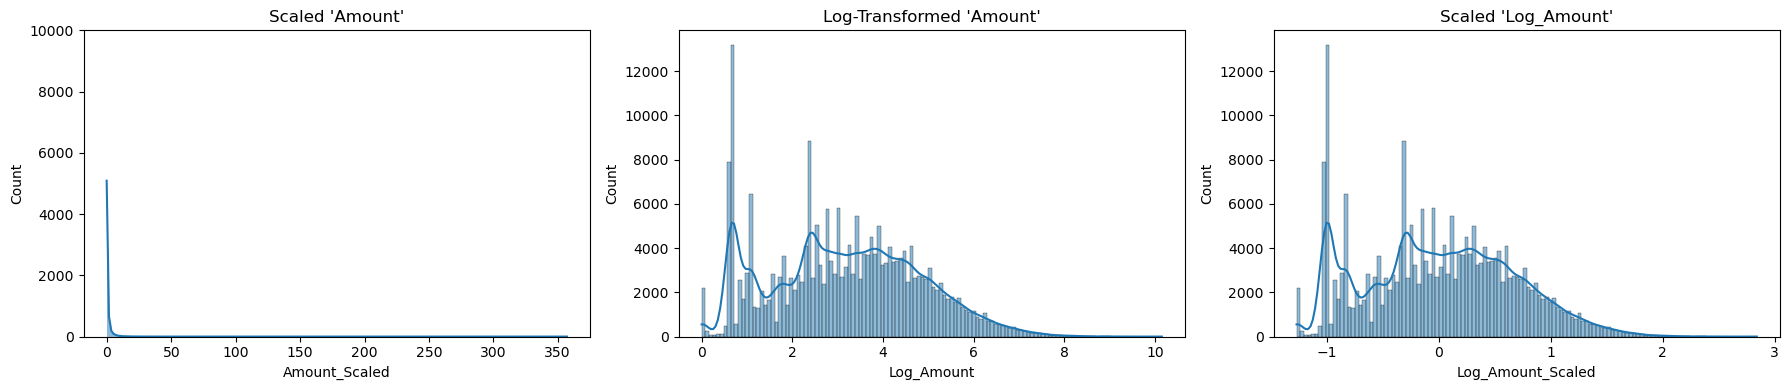

In [6]:
#Check the distributions of 'Log_Amount', 'Log_Amount_Scaled', and 'Amount_Scaled'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(X_train_raw['Amount_Scaled'], ax=axes[0], kde=True).set(title="Scaled 'Amount'")
sns.histplot(X_train_raw['Log_Amount'], ax=axes[1], kde=True).set(title="Log-Transformed 'Amount'")
sns.histplot(X_train_raw['Log_Amount_Scaled'], ax=axes[2], kde=True).set(title="Scaled 'Log_Amount'")
axes[0].set_ylim(0,10000)
plt.tight_layout()
plt.show()

In [7]:
#Check the descriptive statistics of the data
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
X_train_raw.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Log_Amount,Amount_Scaled,Log_Amount_Scaled
count,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00,227845.00
mean,94885.09,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,88.18,3.15,0.92,0.01
std,47488.42,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,0.99,0.96,0.92,0.87,0.84,0.84,0.81,0.77,0.73,0.73,0.63,0.61,0.52,0.48,0.40,0.33,250.72,1.66,3.49,0.67
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00,-0.31,-1.27
25%,54228.00,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.40,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.64,1.89,-0.23,-0.50
50%,84805.00,0.02,0.06,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.01,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,3.14,0.00,0.00
75%,139364.00,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.49,4.36,0.77,0.50
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.57,39.42,27.20,10.50,22.53,4.58,6.07,3.52,31.61,33.85,25691.16,10.15,357.26,2.84


- Since Log_Amount_Scaled is better than Amount, Log_Amount and Amount_Scaled based on skewness and where it is centered, only keep Log_Amount_Scaled from the four variations of Amount

In [8]:
#Drop 'Amount', 'Time', 'Log_Amount', 'Amount_Scaled'
X_train = X_train_raw.drop(columns=['Amount', 'Time', 'Log_Amount', 'Amount_Scaled'])

In [9]:
#Save the robust scaler applied to create Log_Amount_Scaled
joblib.dump(scaler, '../data/robust_scaler.pkl')

['../data/robust_scaler.pkl']

In [10]:
scaler_loaded = joblib.load('../data/robust_scaler.pkl')

In [11]:
#Apply the same transformation to X_test_raw
X_test_raw['Log_Amount'] = np.log1p(X_test_raw['Amount'])
X_test_raw['Log_Amount_Scaled'] = scaler_loaded.transform(X_test_raw[['Log_Amount']])
X_test = X_test_raw.drop(columns=['Amount', 'Time', 'Log_Amount'])


In [12]:
#Apply SMOTE to training dataset to handle class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

/opt/anaconda3/envs/portfolioenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [13]:
#Confirm resampling in X
X_train['V1'].count()

227845

In [14]:
X_res['V1'].count()

454902

In [15]:
#Confirm class balance for y
print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_res.value_counts())

Before SMOTE:
 Class
0    227451
1       394
Name: count, dtype: int64

After SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64


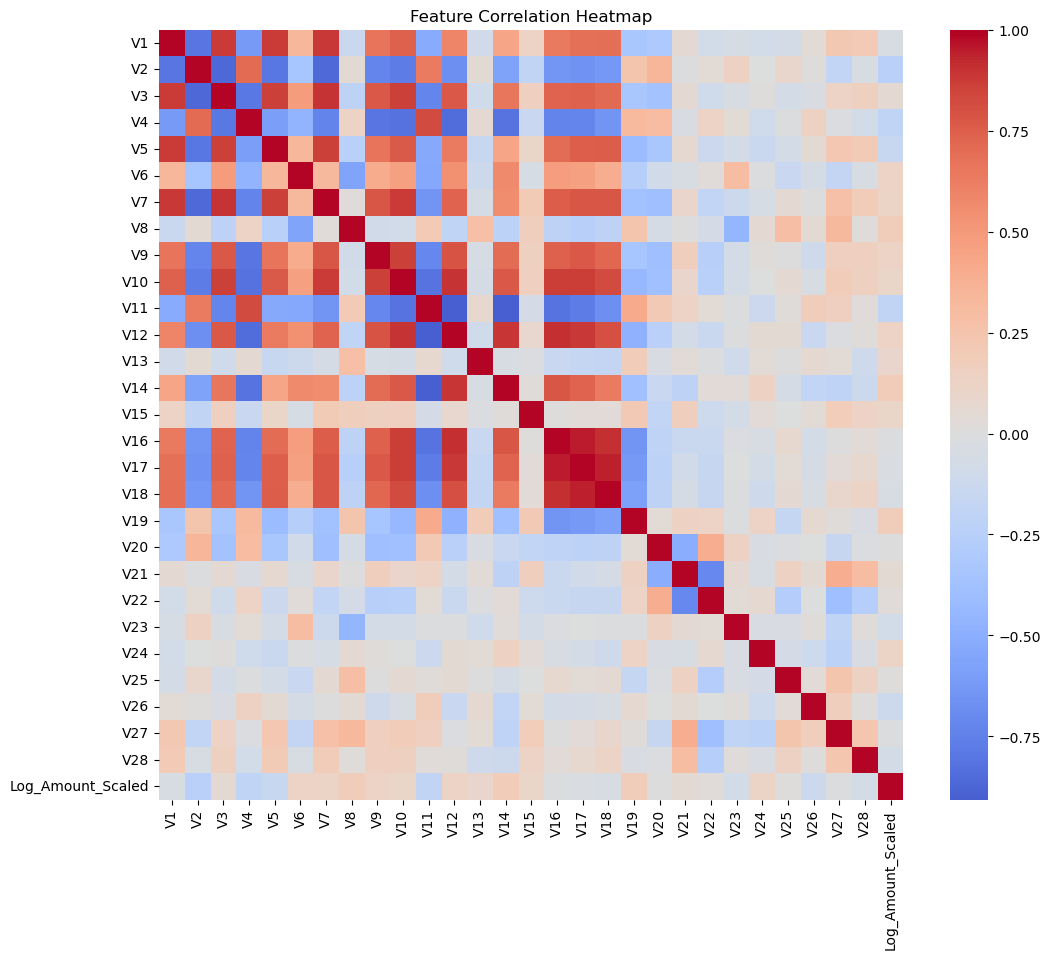

In [16]:
#Create correlation matrix of X_res
corr_mat = X_res.corr()

#Plot heatmap (blue = negative, red = positive correlation)
plt.figure(figsize = (12,10))
sns.heatmap(corr_mat, cmap = 'coolwarm', center = 0)
plt.title('Feature Correlation Heatmap')
plt.show()

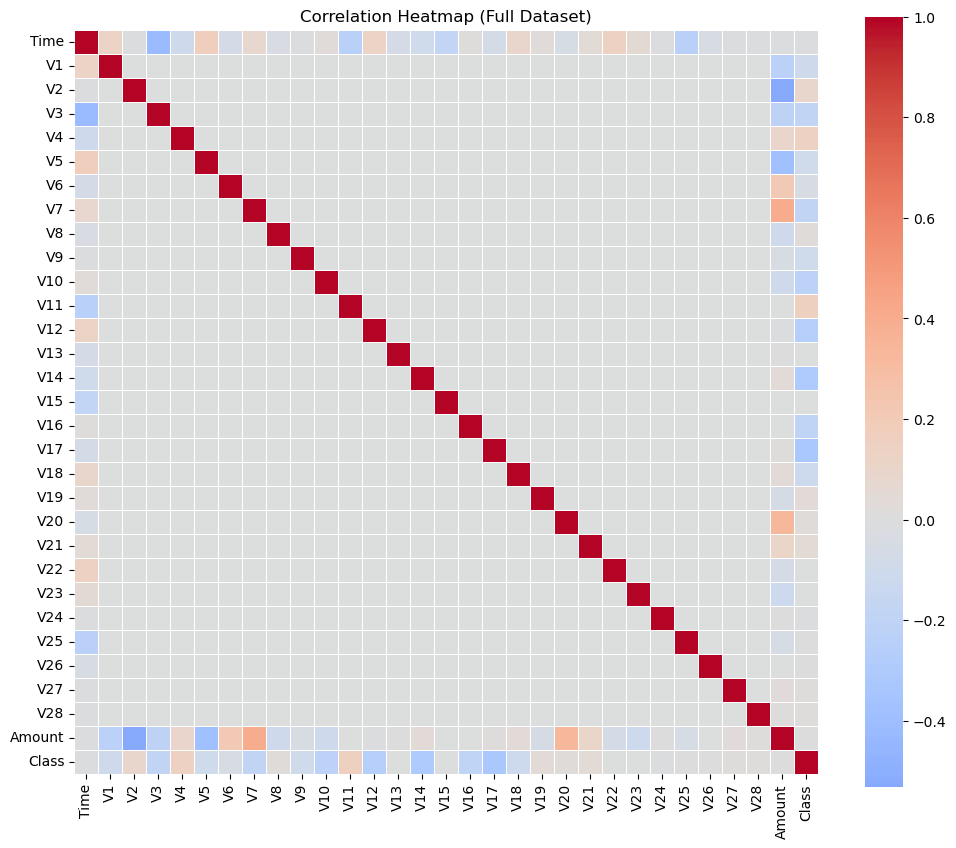

In [17]:
#Correlation heatmap (original data)
corr = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap (Full Dataset)')
plt.show()

- Looking at the two heatmaps, high correlations among some covariates are present only after SMOTE. This makes sense because SMOTE balances the data by adding synthetic cases.

- I am not going to drop any covariates based on this because the pre-SMOTE data do not show high correlations among covariates (e.g., |corr| > 0.8). I will train the data on post-SMOTE data as is, but test the resulting model on the test data which did not go through SMOTE.

In [18]:
#Save the train/test data
import joblib #Better for large numpy arrays/ML models than pickle

joblib.dump(X_train_raw, '../data/X_train_raw.pkl')
joblib.dump(X_test_raw, '../data/X_test_raw.pkl')

joblib.dump(X_test, '../data/X_test.pkl')
joblib.dump(y_test, '../data/y_test.pkl')

joblib.dump(X_res, '../data/X_res.pkl')
joblib.dump(y_res, '../data/y_res.pkl')

['../data/y_res.pkl']

**Next Step**
- Apply and compare several ML models using the preprocessed data here: logistic regression, Random Forest, XGBoost, LightGBM, Isolation Forest, Local Outlier Factor (LOF), and Support Vector Machine (SVM)